# Coding Google's Heat Dissipation Challenge in TensorFlow

> This repository is inspired from [Joel Grus's fizz buzz in TensorFlow](http://joelgrus.com/2016/05/23/fizz-buzz-in-tensorflow/). 

Every year, Google has this challenge [at the CS Games](https://2018.csgames.org/) where you need to find errors in some code. A classic. It's not a competition, just a side challenge simply awaiting to be solved by whoever would like to do so in between the competitions.

So I decided to code this challenge in TensorFlow. It's about heat dissipation. For one of the challenges, some C++ code is given: we have a 5x5 matrix on which we need to perform heat dissipation. There are threads and many broken things. We are asked to find the flaws in the code and repair it. 

For fun's sake, let's instead model the problem with TensorFlow!

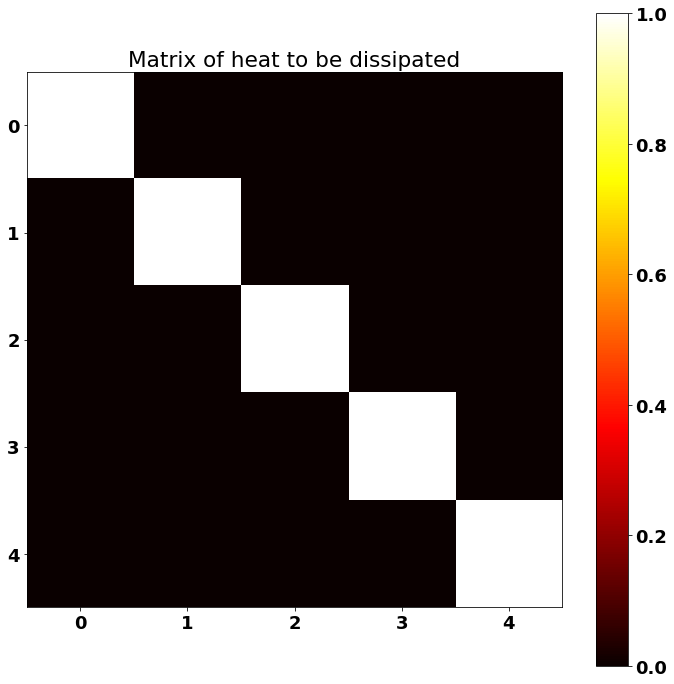

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import time


# The matrix.
border_size = 5
d2_input_matrix = np.eye(border_size)
input_matrix = np.expand_dims(np.expand_dims(d2_input_matrix, axis=-1), axis=0)


# Plotting.
%matplotlib inline
font = {
    'family': 'Bitstream Vera Sans',
    'weight': 'bold',
    'size': 18
}
matplotlib.rc('font', **font)
width = 12
height = 12
plt.figure(figsize=(width, height))
plt.imshow(d2_input_matrix, cmap='hot')
plt.colorbar()
plt.title("Matrix of heat to be dissipated")
plt.show()

## Heat dissipation with TensorFlow: initializing the matrix in the GPU

Note: test if you have a valid TensorFlow-GPU installation. If GPU is supported, TensorFlow will automatically chose the GPU if it is available.

In [2]:
tf.reset_default_graph()
sess = tf.InteractiveSession()  # sess = tf.Session()

tf_input = tf.Variable(
    tf.constant(0.0, shape=[1, border_size, border_size, 1]),
    trainable=False,
    name="Input"
)

tf_input_placeholder = tf.placeholder(tf.float32, shape=[1, border_size, border_size, 1])
tf_input_init = tf_input.assign(tf_input_placeholder)
_ = sess.run(
    tf_input_init, 
    feed_dict={
        tf_input_placeholder: input_matrix
    }
)
print("Tf matrix initialized.")

Tf matrix initialized.


Now, let's create the operation to apply the heat dissipation filter to the matrix. We need to initialize the dissipation filter in the GPU, too. We use a dissipation filter that looks like a `+` and iterate. Applying this square-ish filter many times does the effect of a gaussian blur dissipation. 

In [3]:
precision = 1e-5
dissipation_filter = np.array([
    [0,         precision,         0        ],
    [precision, 1 - 4 * precision, precision],
    [0,         precision,         0        ]
], dtype=np.float32)  # Sums up to 1.0
dissipation_filter = np.expand_dims(dissipation_filter, axis=-1)
dissipation_filter = np.expand_dims(dissipation_filter, axis=-1)

tf_dissipation_filter = tf.convert_to_tensor(dissipation_filter)
print("Tf dissipation filter initialized.")

def dissipate_heat(tf_input, tf_dissipation_filter):
    # Mirror padding on borders and corners for idealized physical setting.
    tf_padded = tf_input
    _, a0, a1, _ = tf_padded.get_shape()
    tf_padded = tf.concat([tf_padded[:, :, 0:1, :], tf_padded, tf_padded[:, :, a1-1:a1, :]], axis=2)
    tf_padded = tf.concat([tf_padded[:, 0:1, :, :], tf_padded, tf_padded[:, a0-1:a0, :, :]], axis=1)
    
    # Apply one heat dissipation, which removes borders because of valid padding.
    tf_changed_input = tf.nn.conv2d(
        tf_padded,
        tf_dissipation_filter, 
        strides=[1, 1, 1, 1],
        padding="VALID")

    return tf_changed_input

Tf dissipation filter initialized.


## Let's use a TensorFlow loop to pass the filter many times

The number of passes we do is similar to moving forward in time. 

In [4]:
tf_nb_passes = tf.placeholder(tf.int32)

i0 = tf.constant(0)
m0 = tf_input
c = lambda i, m: i < tf_nb_passes
b = lambda i, m: [i+1, dissipate_heat(m, tf_dissipation_filter)]
_, tf_changed_input = tf.while_loop(
    c, b, loop_vars=[i0, m0],
    shape_invariants=[i0.get_shape(), m0.get_shape()])

# Updating tf_input to keep progress looped so far.
tf_dissipate_heat = tf_input.assign(tf_changed_input)

_ = """
nb_passes = tf.placeholder(tf.int32)

# for i in range(NB_PASSES):
#     result = sess.run(tf_dissipate_heat)

i = tf.constant(0)
condition = lambda i: tf.less(i, nb_passes)
function = lambda i: dissipate_heat(tf_input, tf_dissipation_filter, i)
loop = tf.while_loop(condition, function, [i])
tf_result = loop[-1]
"""

In [5]:
start_time = time.time()

TIME_UNITS = 1.0  # Let's loop for 1 physical unit of time. 
nb_passes = int(round(TIME_UNITS/precision))

result = sess.run(
    tf_dissipate_heat, 
    feed_dict={
        tf_nb_passes: nb_passes
    }
)

end_time = time.time()
print("Executing {} iterations took {} seconds.".format(nb_passes, time.time() - start_time))

Executing 100000 iterations took 4.603790283203125 seconds.


Note: the code is optimized to work with a GPU, but the above time is calculated on an Intel i7 quad core CPU. 

TensorFlow will still use multiple cores despite running on CPU. 

## Plotting the heat dissipation result

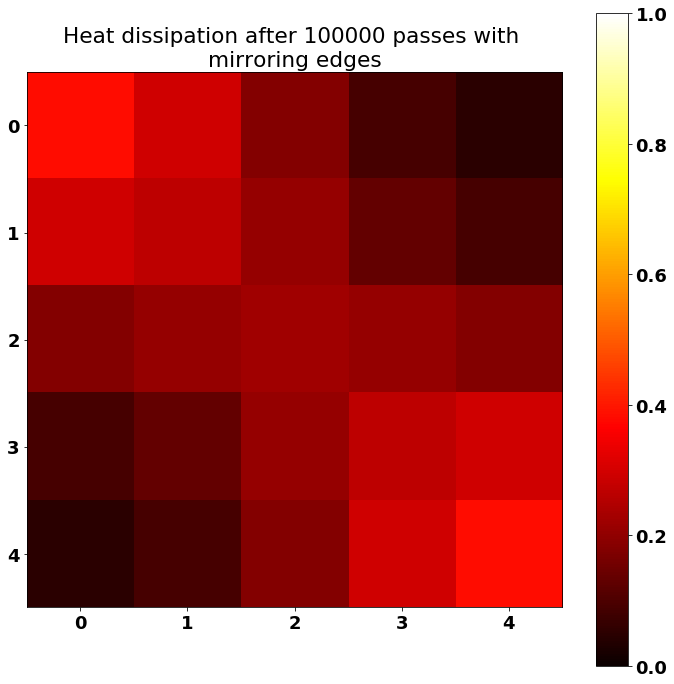

In [6]:
font = {
    'family': 'Bitstream Vera Sans',
    'weight': 'bold',
    'size': 18
}
matplotlib.rc('font', **font)
width = 12
height = 12
plt.figure(figsize=(width, height))
plt.imshow(result[0, :, :, 0], cmap='hot')
plt.colorbar()
plt.clim(0, 1)
plt.title("Heat dissipation after {} passes with \n"
          "mirroring edges".format(nb_passes))
plt.show()

Because of the mirroring edges that we added, it's possible to see that heat is more kept on the corners of the identity heat matrix. 

## Finally, check if numerical errors are reasonnable

In [7]:
res = np.sum(result)
ref = np.sum(input_matrix)
relative_error = abs(ref - res) / ref * 100
print("Approximative relative error is of {}% (a.k.a. approximately {}% correct).".format(
    relative_error, 
    100 - relative_error))

Approximative relative error is of 0.05558967590332031% (a.k.a. approximately 99.94441032409668% correct).


## Conclusion

Numerical errors could be compared to a reference value to find the best tradeoff between the `precision` and the `nb_iters` variables (see above). Those two parameters are inversely linked one to another to apply the transformation on the same time difference. On one hand, a precision too small will require so many iterations that we'll accumulate numerical errors such as calculated above, since the number of iterations needs to be higher. On the other hand, having a precision value too coarse (high value) will enable fewer iterations, thus accumulating less numerical errors, but more modeling errors, deviating from the true comportment which should be continuous. 

In [8]:
# Let's convert this notebook to a README for the GitHub project's title page:
!jupyter nbconvert --to markdown Challenge.ipynb
!mv Challenge.md README.md

[NbConvertApp] Converting notebook Challenge.ipynb to markdown
[NbConvertApp] Support files will be in Challenge_files/
[NbConvertApp] Making directory Challenge_files
[NbConvertApp] Making directory Challenge_files
[NbConvertApp] Writing 7349 bytes to Challenge.md
